In [1]:
import numpy as np
from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import stats

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
import math

from scipy.ndimage import gaussian_filter1d

In [2]:
h = 1
H0 = 100*h
c = 299792

In [3]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA[:10]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [4]:
boolean = SGA['Z_LEDA'] < 0
SGA['Z_LEDA'][boolean] = np.nan
print(np.sum(np.isnan(SGA['Z_LEDA'])))
print(np.sum(np.isfinite(SGA['Z_LEDA'])))

118903
264715


In [5]:
x = SGA['Z_LEDA'][::10]
x.info('stats')

name = Z_LEDA
mean = 0.0652868
std = 0.0394935
min = 0.000137095
max = 0.885476
n_bad = 0
length = 38362


In [6]:
d = (SGA['Z_LEDA']*c)/H0
dist = d * (1000000)
print(np.sum(np.isfinite(d)))

264715


In [7]:
inside_log = dist/(10.0)

In [8]:
boolean = SGA['R_MAG_SB26'] < 0
SGA['R_MAG_SB26'][boolean] = np.nan
print(np.sum(np.isnan(SGA['R_MAG_SB26'])))

20831


In [9]:
r_abs_SB26 = SGA['R_MAG_SB26'] - (5*((np.log10(inside_log))))

/tmp/ipykernel_6459/3556034399.py:1: RuntimeWarning: divide by zero encountered in log10
  r_abs_SB26 = SGA['R_MAG_SB26'] - (5*((np.log10(inside_log))))


# FLAT PLANE WITH SEMI MAJOR AXIS, MAGNITUDE, AND REDSHIFT

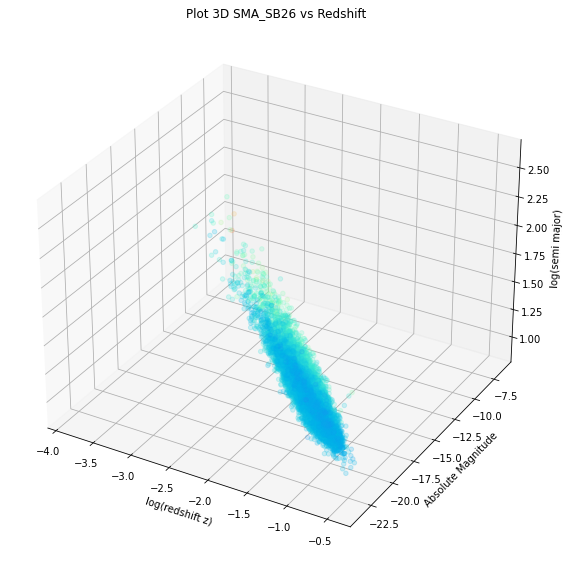

In [39]:
plt.figure(figsize=(8, 8), tight_layout=True)
ax = plt.axes(projection ='3d')
ax.set_xlabel('log(redshift z)')
ax.set_ylabel('Absolute Magnitude')
ax.set_zlabel('log(semi major)')

# Grab the 3 parameters we want.
y = r_abs_SB26[::20]
x = SGA['Z_LEDA'][::20]
z = SGA['SMA_SB26'][::20]
sigma1 = SGA['SMA_SB26_ERR'][::20]

# Select positive z to avoid log(negative value)
# Use proportionality between errors on semi major axis and diameter
select = z > 0.
x, y, z = x[select], y[select], z[select]
logx = np.log10(x)
log_semimajor = np.log10(z)
sigma_logd26 = (1/log_semimajor) * sigma1[select]
# sigma_logz = np.ones_like(logz) * 0.1

ax.scatter(logx, y, log_semimajor, alpha = 0.2, c = y, vmin= -29, vmax=-1, cmap= plt.cm.get_cmap('rainbow'))
ax.set_title('Plot 3D SMA_SB26 vs Redshift')
plt.show()

In [62]:
# Fit the data: flat plane fit to x=log(redshift), y=abs mag, z=log(angular size)
def chi2t2(params, x, y, z, sigma):
    a, b, c = params
    return ((np.sum(((z - (a*x + b*y + c)) / sigma)**2))/(362851-3))
y1 = r_abs_SB26
x1 = SGA['Z_LEDA']
z1 = SGA['SMA_SB26']
sigma1 = SGA['SMA_SB26_ERR']

select = z1 > 0.
x, y, z = x1[select], y1[select], z1[select]
logx = np.log10(x)
log_semimajor = np.log10(z)
sigma_logd26 = (1/log_semimajor) * sigma1[select]

seed = [-4.4, -2.2, -4.3]

# Minimize.
# If the termination is not successful due to a numerical issue, consider changing the tolerance.
# Specify tol=1e-6 and then increase until the fit works (tol=1e-5, 1e-4, ...).
rest = minimize(chi2t2, seed, args=(logx, y, log_semimajor, sigma_logd26), method='Nelder-Mead')
# rest = minimize(chi2t2, seed, args=(logx, y, logz, sigma_logz), method='BFGS', tol=1e-2)

print(f'min chi2 = {rest.fun:.3f}\n')
print(rest)

/tmp/ipykernel_6459/10748992.py:12: RuntimeWarning: divide by zero encountered in log10
  logx = np.log10(x)


min chi2 = 0.709

 final_simplex: (array([[-0.73839401, -0.13348533, -2.33464094],
       [-0.73839214, -0.13348476, -2.33463019],
       [-0.73837956, -0.13348145, -2.33454697],
       [-0.73837587, -0.13348233, -2.33456076]]), array([0.7087866, 0.7087866, 0.7087866, 0.7087866]))
           fun: 0.7087866034820557
       message: 'Optimization terminated successfully.'
          nfev: 259
           nit: 141
        status: 0
       success: True
             x: array([-0.73839401, -0.13348533, -2.33464094])


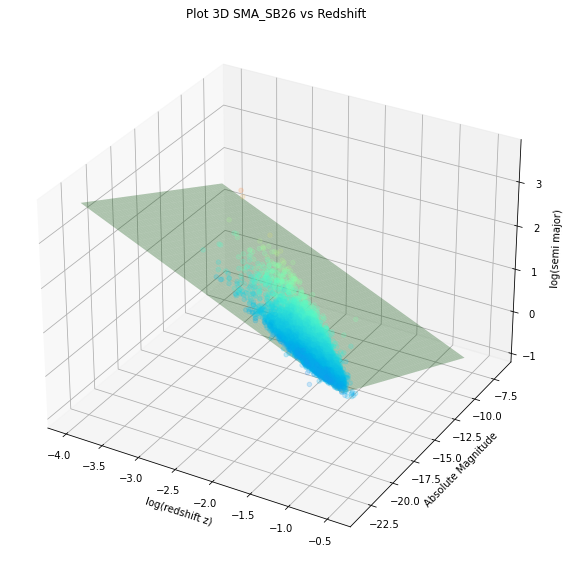

In [63]:
plt.figure(figsize=(8, 8), tight_layout=True)
ax = plt.axes(projection ='3d')
ax.set_xlabel('log(redshift z)')
ax.set_ylabel('Absolute Magnitude')
ax.set_zlabel('log(semi major)')

y = r_abs_SB26[::20]
x = SGA['Z_LEDA'][::20]
z = SGA['SMA_SB26'][::20]
sigma1 = SGA['SMA_SB26_ERR'][::20]

# Select positive z to avoid log(negative value)
# Use proportionality between errors on semi major axis and diameter
select = z > 0.
x, y, z = x[select], y[select], z[select]
logx = np.log10(x)
log_semimajor = np.log10(z)
sigma_logd26 = (1/log_semimajor) * sigma1[select]
# sigma_logz = np.ones_like(logz) * 0.1

a_, b_, c_ = rest.x
log_redshift = np.arange(-4, -0.5, 0.1)
abs_mag = np.arange(-22.5, -7.5, 0.1)
log_redm, abs_magm = np.meshgrid(log_redshift, abs_mag)
log_size = a_*log_redm +b_*abs_magm + c_
ax.plot_surface(log_redm, abs_magm, log_size, alpha=0.3, color='g')

ax.scatter(logx, y, log_semimajor, alpha=0.2, c=y, vmin= -29, vmax=-1, cmap=plt.cm.get_cmap('rainbow'))
ax.set_title('Plot 3D SMA_SB26 vs Redshift');

# Dispersion of points with respect to the plane 
#### Dispersion for flat plane for diameter on redshift axis

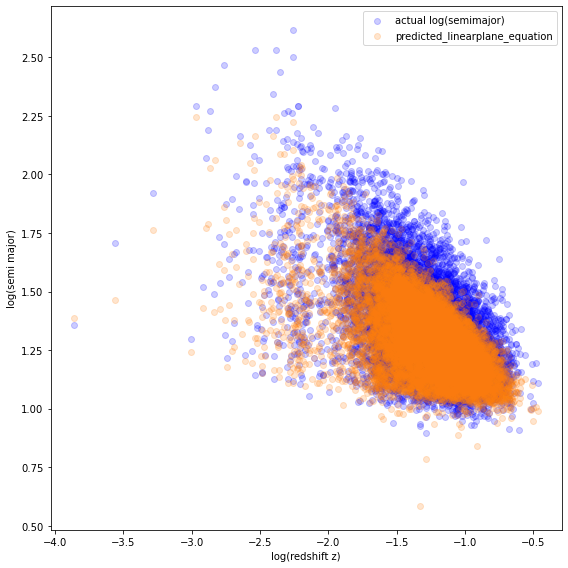

In [44]:
predicted_z1 = -0.73839401 * logx - 0.13348533 * y -2.33464094
plt.figure(figsize=(8,8), tight_layout=True)
plt.scatter(logx, log_semimajor, alpha = 0.2, color = 'b', label = 'actual log(semimajor)')
plt.scatter(logx, predicted_z1, alpha = 0.2, color='tab:orange', label = 'predicted_linearplane_equation')
plt.xlabel('log(redshift z)')
plt.ylabel('log(semi major)')
plt.legend();

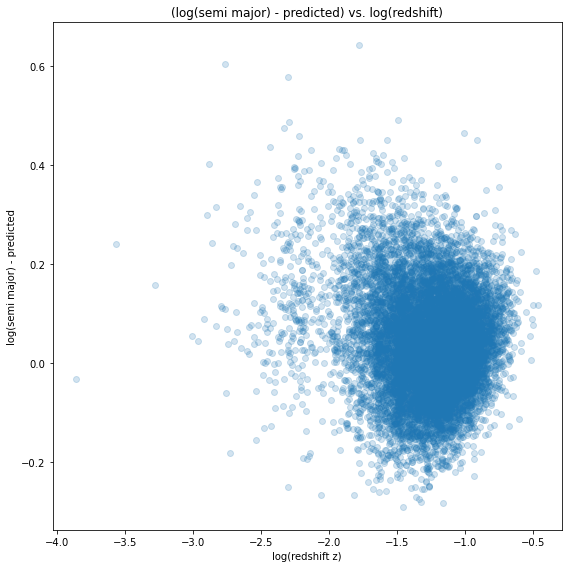

In [45]:
dispersion = log_semimajor - predicted_z1
plt.figure(figsize=(8,8), tight_layout=True)
plt.scatter(logx, dispersion, alpha = 0.2)
#plt.scatter(logx, predicted_z, alpha = 0.2)
plt.xlabel('log(redshift z)')
plt.ylabel('log(semi major) - predicted');
plt.title('(log(semi major) - predicted) vs. log(redshift)');

#### Dispersion for flat plane for diameter on absolute magnitude axis

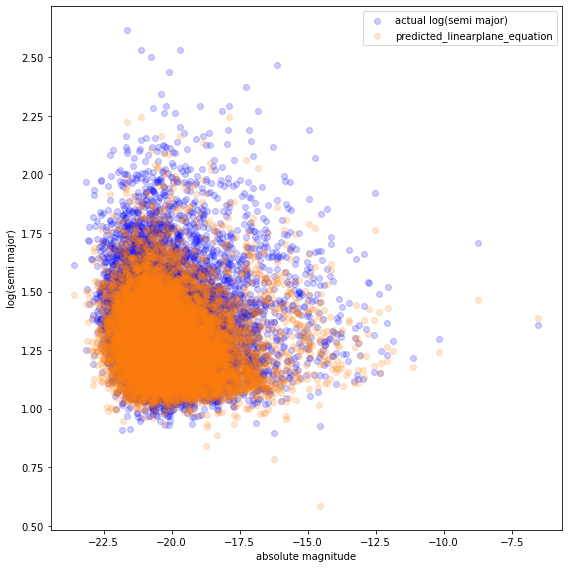

In [46]:
plt.figure(figsize=(8,8), tight_layout=True)
plt.scatter(y, log_semimajor, alpha = 0.2, color = 'b', label = 'actual log(semi major)')
plt.scatter(y, predicted_z1, alpha = 0.2, color='tab:orange', label = 'predicted_linearplane_equation')
plt.xlabel('absolute magnitude')
plt.ylabel('log(semi major)')
plt.legend();

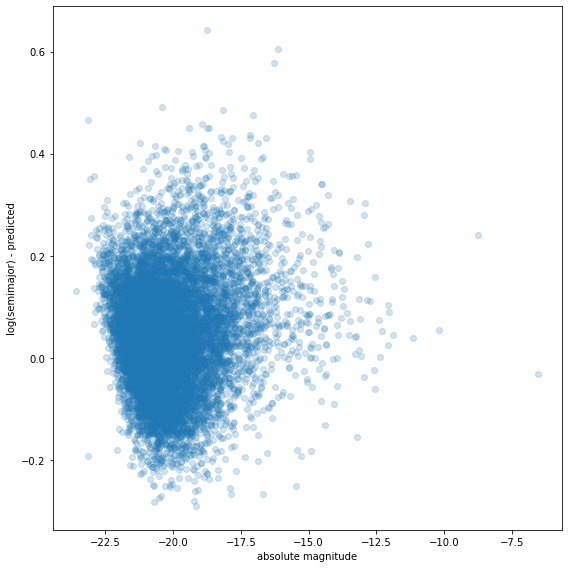

In [47]:
dispersion = log_semimajor - predicted_z1
plt.figure(figsize=(8,8), tight_layout=True)
plt.scatter(y, dispersion, alpha = 0.2)
#plt.scatter(logx, predicted_z, alpha = 0.2)
plt.xlabel('absolute magnitude')
plt.ylabel('log(semimajor) - predicted');

#### 3D Residual plot for flat plane 

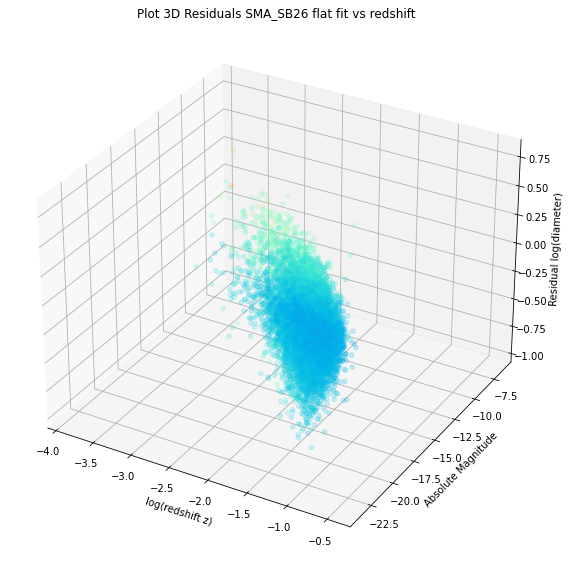

In [49]:
plt.figure(figsize=(8, 8), tight_layout=True)
ax = plt.axes(projection ='3d')
ax.set_xlabel('log(redshift z)')
ax.set_ylabel('Absolute Magnitude')
ax.set_zlabel('Residual log(diameter)')

a_, b_, c_ = rest.x
flat_fiteq =  a_*logx +b_*y + c_ 
residuals = (z - (10**flat_fiteq))/z
ax.scatter(logx, y, residuals, alpha=0.2, c=y, vmin= -29, vmax=-1, cmap=plt.cm.get_cmap('rainbow'))
ax.set_title('Plot 3D Residuals SMA_SB26 flat fit vs redshift');

# PLOT WITH CURVATURE, DIAMETER vs MAGNITUDE vs REDSHIFT

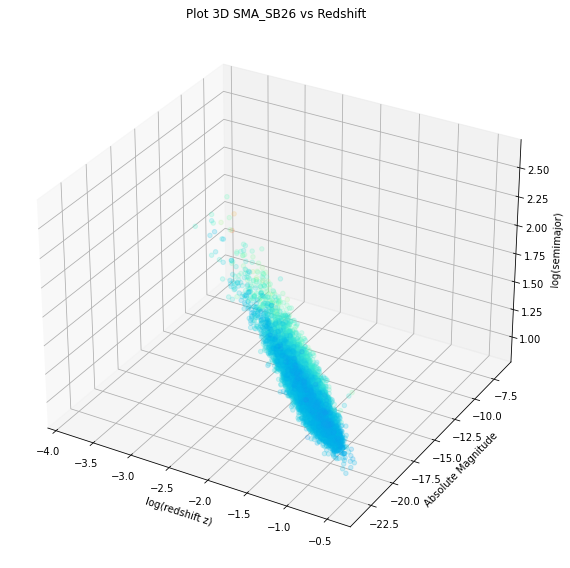

In [66]:
plt.figure(figsize=(8, 8), tight_layout=True)
ax = plt.axes(projection ='3d')
ax.set_xlabel('log(redshift z)')
ax.set_ylabel('Absolute Magnitude')
ax.set_zlabel('log(semimajor)')

# Grab the 3 parameters we want.
y1 = r_abs_SB26[::20]
x1 = SGA['Z_LEDA'][::20]
z1 = SGA['SMA_SB26'][::20]
sigma2 = SGA['SMA_SB26_ERR'][::20]

# Select positive z to avoid log(negative value)
# Use proportionality between errors on semi major axis and diameter
select = z1 > 0.
x, y, z = x1[select], y1[select], z1[select]
logx = np.log10(x)
log_semimajor = np.log10(z)
sigma_logd26 = (1/log_semimajor) * sigma2[select]
# sigma_logz = np.ones_like(logz) * 0.1

ax.scatter(logx, y, log_semimajor, alpha = 0.2, c = y, vmin= -29, vmax=-1, cmap= plt.cm.get_cmap('rainbow'))
ax.set_title('Plot 3D SMA_SB26 vs Redshift')
plt.show()

In [67]:
# add curvature to x=log(redshift), keeping y=abs mag, z=log(angular size) linear
def chi2t2(params, x, y, z, sigma):
    a, b, c = params
    return ((np.sum(((z - (a*(x**2) + b*x + c*y + d)) / sigma)**2))/(362851-4))

y1 = r_abs_SB26
x1 = SGA['Z_LEDA']
z1 = SGA['SMA_SB26']
sigma2 = SGA['SMA_SB26_ERR']

select = z1 > 0.
x, y, z = x1[select], y1[select], z1[select]
logx = np.log10(x)
log_semimajor = np.log10(z)
sigma_logd26 = (1/log_semimajor) * sigma2[select]
len(y)


/tmp/ipykernel_6459/2496764995.py:13: RuntimeWarning: divide by zero encountered in log10
  logx = np.log10(x)


362851

In [68]:
# add curvature to x=log(redshift), keeping y=abs mag, z=log(angular size) linear
def chi2t2(params, x, y, z, sigma):
    a, b, c = params
    return ((np.sum(((z - (a*(x**2) + b*x + c*y + d)) / sigma)**2))/(383620-4))

y1 = r_abs_SB26
x1 = SGA['Z_LEDA']
z1 = SGA['SMA_SB26']
sigma1 = SGA['SMA_SB26_ERR']

select = z1 > 0.
x, y, z = x1[select], y1[select], z1[select]
logx = np.log10(x)
log_semimajor = np.log10(z)
sigma_logd26 = (1/log_semimajor) * sigma2[select]

seed = [-4.4, -2.2, -4.3]

# Minimize.
# If the termination is not successful due to a numerical issue, consider changing the tolerance.
# Specify tol=1e-6 and then increase until the fit works (tol=1e-5, 1e-4, ...).
rest = minimize(chi2t2, seed, args=(logx, y, log_semimajor, sigma_logd26), method='Nelder-Mead')
# rest = minimize(chi2t2, seed, args=(logx, y, logz, sigma_logz), method='BFGS', tol=1e-2)

print(f'min chi2 = {rest.fun:.3f}\n')
print(rest)

/tmp/ipykernel_6459/663130141.py:13: RuntimeWarning: divide by zero encountered in log10
  logx = np.log10(x)


ValueError: operands could not be broadcast together with shapes (362851,) (383620,) 

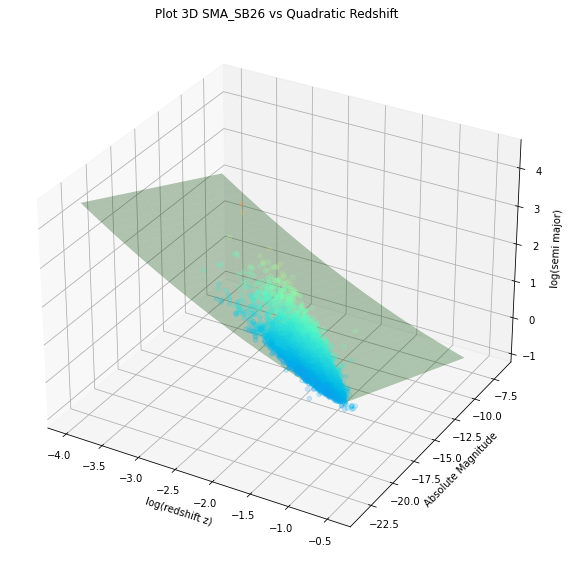

In [26]:
plt.figure(figsize=(8, 8), tight_layout=True)
ax = plt.axes(projection ='3d')
ax.set_xlabel('log(redshift z)')
ax.set_ylabel('Absolute Magnitude')
ax.set_zlabel('log(semi major)')

y = r_abs_SB26[::20]
x = SGA['Z_LEDA'][::20]
z = SGA['SMA_SB26'][::20]
sigma1 = SGA['SMA_SB26_ERR'][::20]

# Select positive z to avoid log(negative value)
# Use proportionality between errors on semi major axis and diameter
select = z > 0.
x, y, z = x[select], y[select], z[select]
logx = np.log10(x)
log_semimajor = np.log10(z)
sigma_logd26 = (1/log_semimajor) * sigma1[select]
# sigma_logz = np.ones_like(logz) * 0.1

a_, b_, c_, d_ = rest.x
log_redshift = np.arange(-4, -0.5, 0.1)
abs_mag = np.arange(-22.5, -7.5, 0.1)
log_redm, abs_magm = np.meshgrid(log_redshift, abs_mag)
log_size = a_*(log_redm **2) + b_*log_redm + c_*abs_magm + d_
ax.plot_surface(log_redm, abs_magm, log_size, alpha=0.3, color='g')

ax.scatter(logx, y, log_semimajor, alpha=0.2, c=y, vmin= -29, vmax=-1, cmap=plt.cm.get_cmap('rainbow'))
ax.set_title('Plot 3D SMA_SB26 vs Quadratic Redshift');

# Dispersion of points with respect to the plane 
#### Dispersion for quadratic plane for diameter on redshift axis

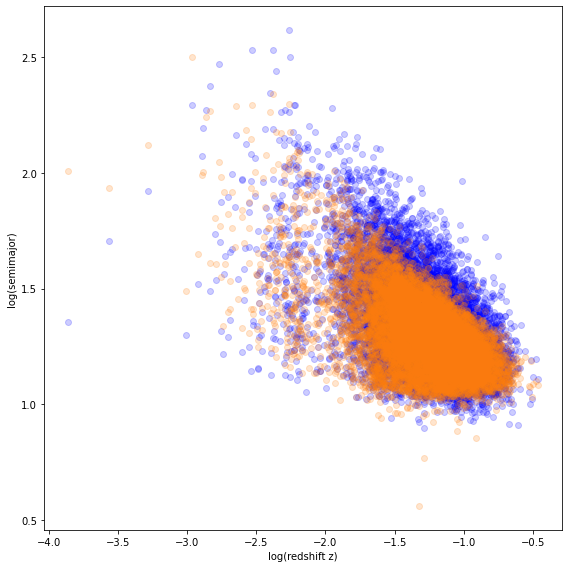

In [27]:
predicted_z2 =  0.10969376 *(logx**2) - (0.43007316 *logx) - (0.13607731*y) - 2.17986571
plt.figure(figsize=(8,8), tight_layout=True)
plt.scatter(logx, log_semimajor, alpha = 0.2, color = 'b', label = 'actual log(semi major)')
plt.scatter(logx, predicted_z2, alpha = 0.2, color='tab:orange', label = 'predicted_quadraticxplane_equation')
plt.xlabel('log(redshift z)')
plt.ylabel('log(semimajor)');

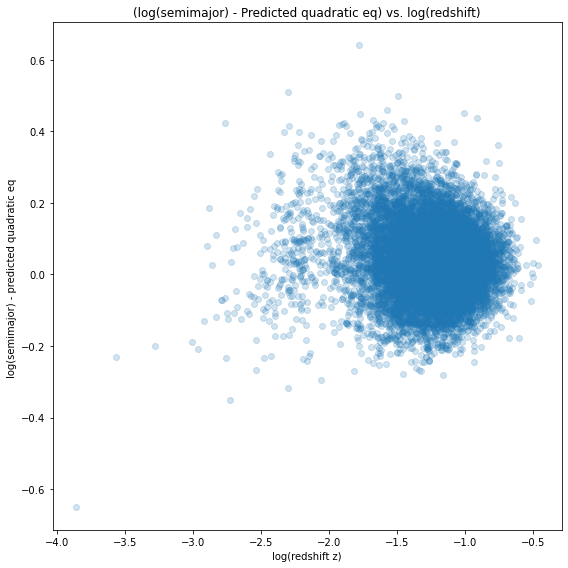

In [28]:
dispersion = log_semimajor - predicted_z2
plt.figure(figsize=(8,8), tight_layout=True)
plt.scatter(logx, dispersion, alpha = 0.2)
#plt.scatter(logx, predicted_z, alpha = 0.2)
plt.xlabel('log(redshift z)')
plt.ylabel('log(semimajor) - predicted quadratic eq ');
plt.title('(log(semimajor) - Predicted quadratic eq) vs. log(redshift)');

#### Dispersion for quadratic plane for diameter on absolute magnitude axis

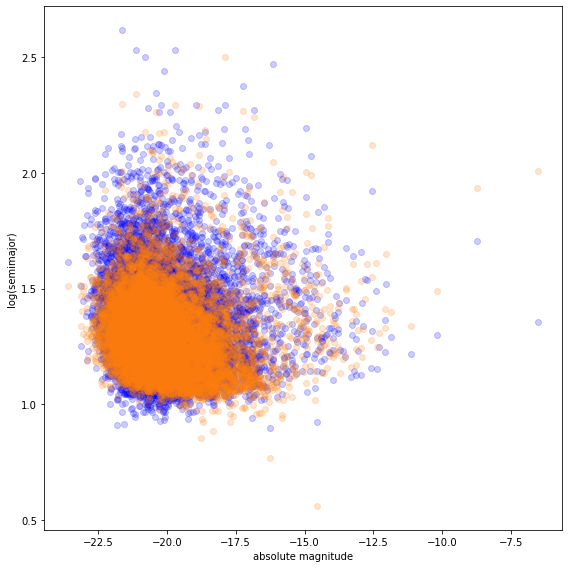

In [29]:
predicted_z2 =  0.10969376 *(logx**2) - (0.43007316 *logx) - (0.13607731*y) - 2.17986571
plt.figure(figsize=(8,8), tight_layout=True)
plt.scatter(y, log_semimajor, alpha = 0.2, color = 'b', label = 'actual log(diameter)')
plt.scatter(y, predicted_z2, alpha = 0.2, color='tab:orange', label = 'predicted_quadraticxplane_equation')
plt.xlabel('absolute magnitude')
plt.ylabel('log(semimajor)');

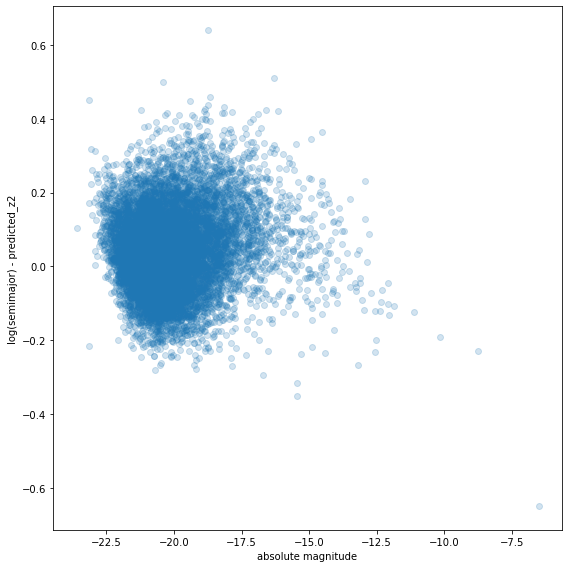

In [30]:
dispersion = log_semimajor - predicted_z2
plt.figure(figsize=(8,8), tight_layout=True)
plt.scatter(y, dispersion, alpha = 0.2)
#plt.scatter(logx, predicted_z, alpha = 0.2)
plt.xlabel('absolute magnitude')
plt.ylabel('log(semimajor) - predicted_z2');

#### 3D Residual plot for quadratic plane 

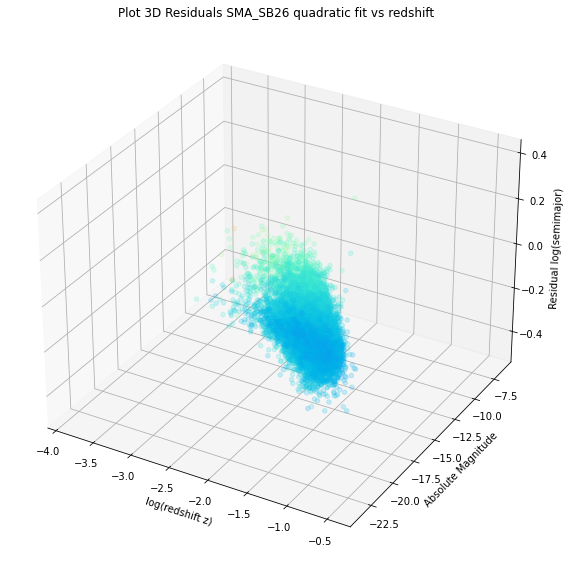

In [31]:
plt.figure(figsize=(8, 8), tight_layout=True)
ax = plt.axes(projection ='3d')
ax.set_xlabel('log(redshift z)')
ax.set_ylabel('Absolute Magnitude')
ax.set_zlabel('Residual log(semimajor)')

a_, b_, c_, d_ = rest.x
quad_fiteq =  a_*(logx**2) +b_*logx + c_*y + d_
residuals2 = (np.log10(z) - (10**quad_fiteq))/np.log10(z)
ax.scatter(logx, y, residuals2, alpha=0.2, c=y, vmin= -29, vmax=-1, cmap=plt.cm.get_cmap('rainbow'))
ax.set_title('Plot 3D Residuals SMA_SB26 quadratic fit vs redshift');